In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../utils/')
from data_utils import get_folders
from train_utils import train
from diagnostic_tools import count_params
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 128

In [5]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

In [6]:
# number of validation samples
val_size = len(val_folder.imgs)
val_size

10000

# Model

In [7]:
from get_squeezenet import get_model

In [8]:
model, criterion, optimizer = get_model()

In [9]:
# number of params in the model
count_params(model)

828066

# Train

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs = 200
n_batches = ceil(train_size/batch_size)

lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=7, 
    verbose=True, threshold=0.01, threshold_mode='abs'
)

# total number of batches in the train set
n_batches

782

In [11]:
%%time
all_losses = train(
    model, criterion, optimizer,
    train_iterator, n_epochs, steps_per_epoch=n_batches,
    val_iterator=val_iterator, n_validation_batches=40,
    patience=14, threshold=0.01, # early stopping
    lr_scheduler=lr_scheduler
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  4.216 3.741  0.114 0.176  0.297 0.407  44.508
1  3.477 3.771  0.220 0.198  0.473 0.428  43.298
2  3.202 3.107  0.269 0.282  0.535 0.559  43.177
3  3.029 3.039  0.298 0.302  0.573 0.569  43.153
4  2.905 2.978  0.324 0.308  0.599 0.581  43.216
5  2.805 2.813  0.343 0.340  0.620 0.621  43.089
6  2.714 2.775  0.360 0.351  0.636 0.626  43.346
7  2.642 2.756  0.375 0.354  0.653 0.628  43.559
8  2.575 2.636  0.388 0.382  0.664 0.658  43.483
9  2.520 2.641  0.398 0.378  0.675 0.654  43.293
10  2.459 2.593  0.411 0.388  0.686 0.667  43.707
11  2.416 2.655  0.419 0.383  0.694 0.659  43.500
12  2.374 2.520  0.429 0.407  0.701 0.681  43.353
13  2.331 2.643  0.436 0.395  0.710 0.669  43.549
14  2.294 2.566  0.446 0.398  0.716 0.672  43.669
15  2.260 2.514  0.450 0.404  0.722 0.679  43.544
16  2.227 2.418  0.456 0.427  0.729 0.694  43.554
17  2.200 2.523  0.462 0.410  0.733 0.680  43.327
18  2.168 2.399  0.469 0.434  0.739 0.706  43.416
19  2.149 2.399  0.472 0.432  0.742 0.701  43.629
20  2.119 

# Loss/epoch plots

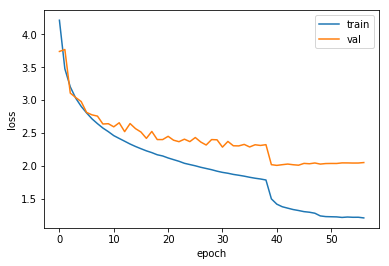

In [12]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

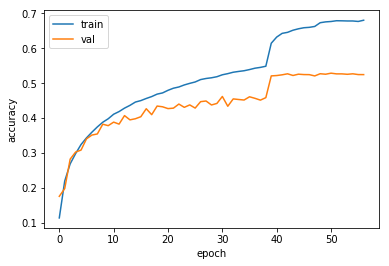

In [13]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

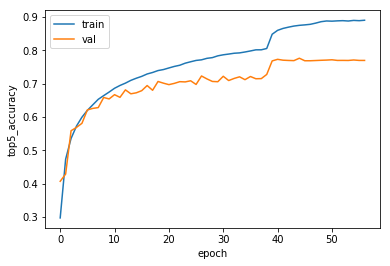

In [14]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [15]:
model.cpu();
torch.save(model.state_dict(), 'model.pytorch_state')